<a href="https://colab.research.google.com/github/danieljtrujillo/DataForecaster/blob/master/DataForecaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import necessary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

In [0]:
!wget -O baesys.csv https://raw.githubusercontent.com/danieljtrujillo/DataForecaster/master/baesys.csv

--2019-09-04 05:30:31--  https://raw.githubusercontent.com/danieljtrujillo/DataForecaster/master/baesys.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84958 (83K) [text/plain]
Saving to: ‘baesys.csv’

baesys.csv          100%[===================>]  82.97K  --.-KB/s    in 0.02s   

2019-09-04 05:30:31 (3.25 MB/s) - ‘baesys.csv’ saved [84958/84958]



In [0]:
df = pd.read_csv('baesys.csv')

In [0]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-03,30.020000,30.020000,29.74,29.799999,24.529020,533400
2014-09-04,29.900000,30.000000,29.60,29.770000,24.504326,784700
2014-09-05,29.809999,29.850000,29.60,29.799999,24.529020,142600
2014-09-08,29.190001,29.219999,28.93,29.030001,23.895220,113900
2014-09-09,29.139999,29.230000,29.00,29.120001,23.969299,226600


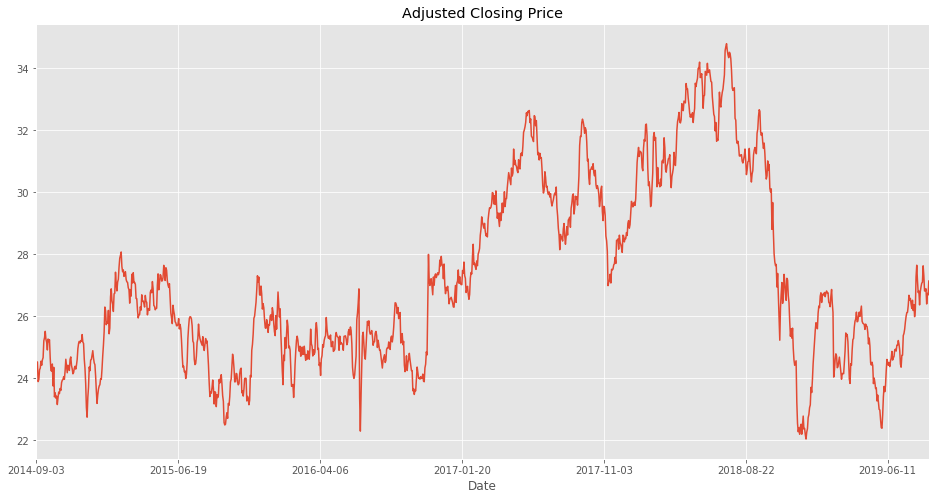

In [0]:
df['Adj Close'].plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [0]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

In [0]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

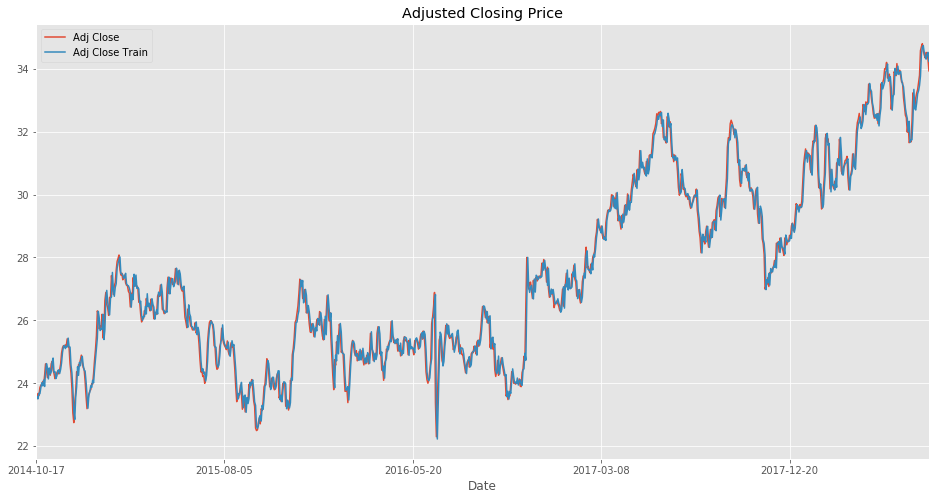

In [0]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

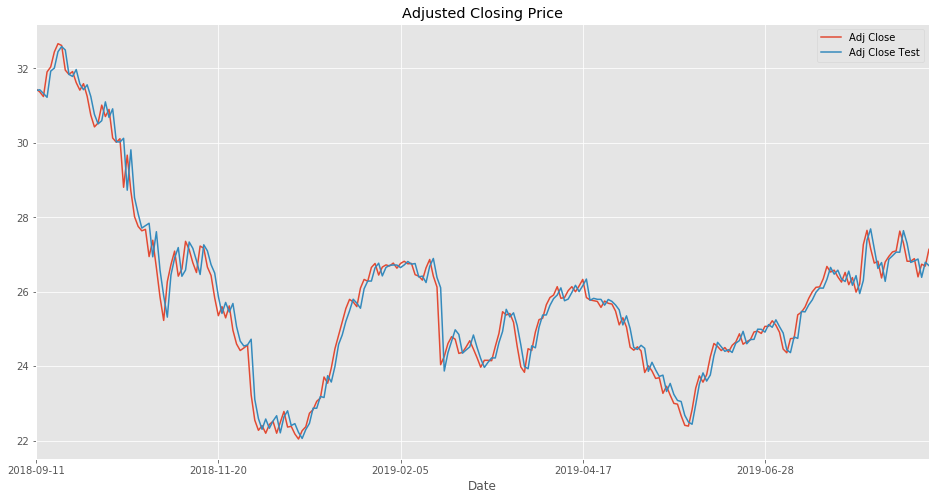

In [0]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [0]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

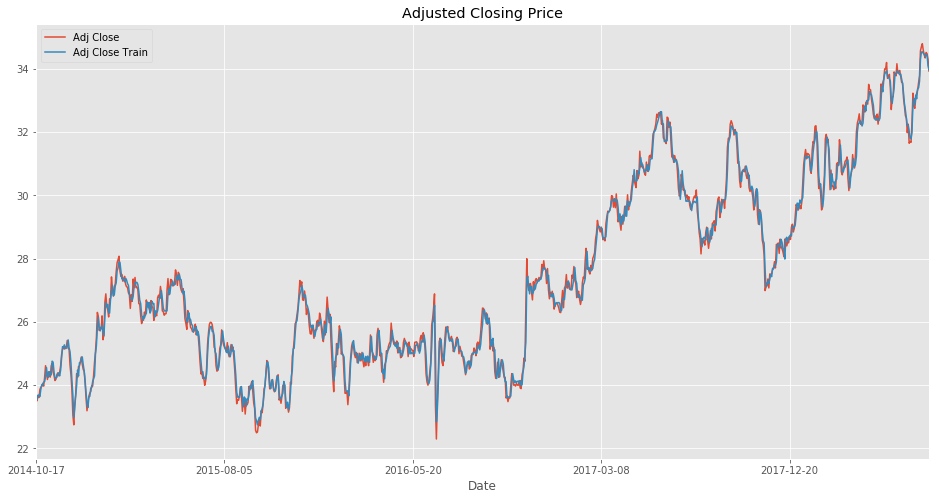

In [0]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

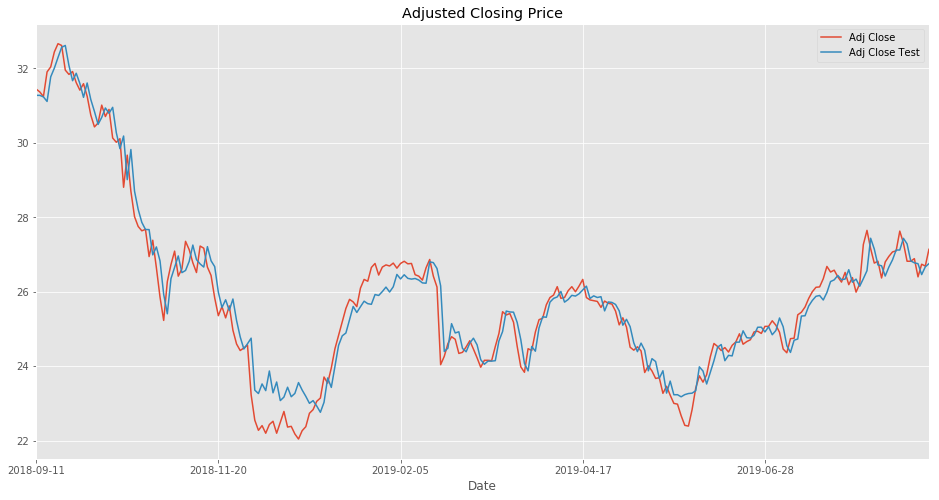

In [0]:
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [0]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total para

In [0]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

In [0]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

W0904 05:35:01.510386 140203094509440 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0904 05:35:03.075067 140203094509440 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0904 05:35:03.146086 140203094509440 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 981 samples, validate on 246 samples
Epoch 1/250
981/981 [==============================] - 5s 5ms/step - loss: 0.1266 - mean_absolute_error: 0.4492 - val_loss: 0.1505 - val_mean_absolute_error: 0.5017
Epoch 2/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1266 - mean_absolute_error: 0.4492 - val_loss: 0.1505 - val_mean_absolute_error: 0.5017
Epoch 3/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1266 - mean_absolute_error: 0.4492 - val_loss: 0.1505 - val_mean_absolute_error: 0.5017
Epoch 4/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1266 - mean_absolute_error: 0.4492 - val_loss: 0.1505 - val_mean_absolute_error: 0.5017
Epoch 5/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1266 - mean_absolute_error: 0.4492 - val_loss: 0.1505 - val_mean_absolute_error: 0.5017
Epoch 6/250
981/981 [==============================] - 2s 2ms/step - loss: 0.1266 - mean_absolute_error: 0.4492 - val_loss: 0.150

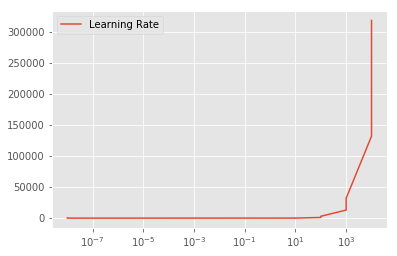

In [102]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

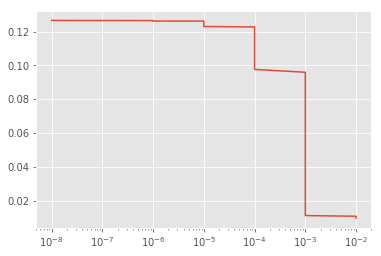

In [103]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

In [104]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 981 samples, validate on 246 samples
Epoch 1/250
981/981 [==============================] - 4s 4ms/step - loss: 0.0673 - mean_absolute_error: 0.2991 - val_loss: 0.0477 - val_mean_absolute_error: 0.2548
Epoch 2/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0300 - mean_absolute_error: 0.1994 - val_loss: 0.0203 - val_mean_absolute_error: 0.1554
Epoch 3/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0222 - mean_absolute_error: 0.1650 - val_loss: 0.0199 - val_mean_absolute_error: 0.1546
Epoch 4/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0153 - mean_absolute_error: 0.1377 - val_loss: 0.0249 - val_mean_absolute_error: 0.1779
Epoch 5/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0129 - mean_absolute_error: 0.1238 - val_loss: 0.0182 - val_mean_absolute_error: 0.1485
Epoch 6/250
981/981 [==============================] - 2s 2ms/step - loss: 0.0113 - mean_absolute_error: 0.1179 - val_loss: 0.022

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

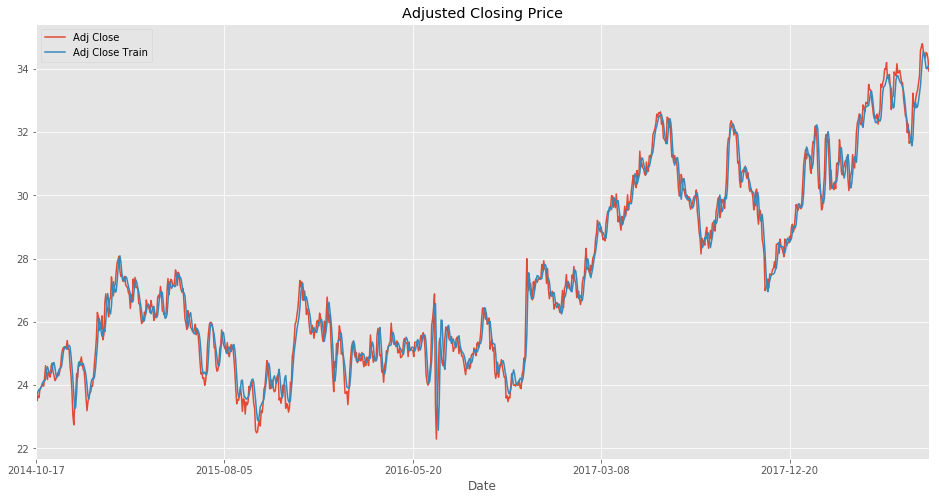

In [107]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)

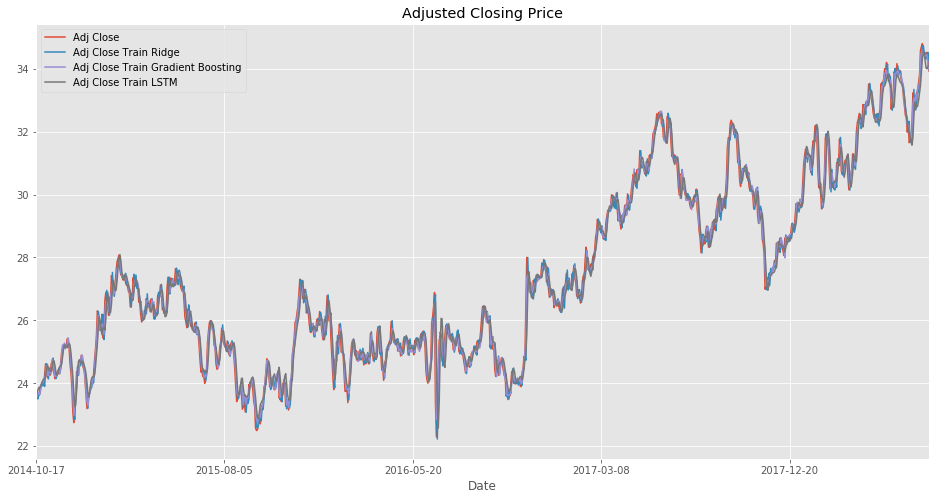

In [109]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)


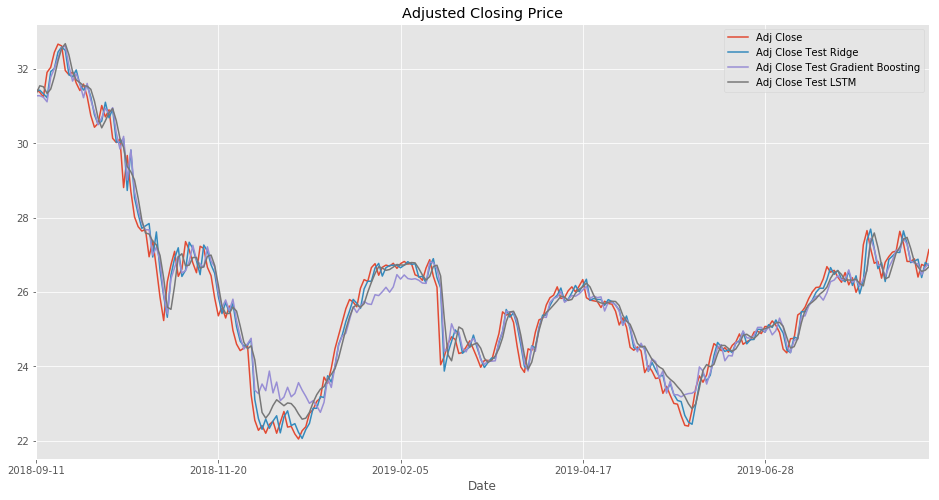

In [110]:
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='BAESY', figsize=(16,8), title='Adjusted Closing Price', grid=True)


In [0]:
num_days = 10 # Let's try and forecase the next 10 days or two years

# Get the last window_size (32) days
data_seed = df['Adj Close'].values[-window_size:][None]
# Get the normalized data as well for the neural network
data_seed_norm = scaler.transform(data_seed)
input_values = {"ridge": data_seed, "gb": data_seed, "keras": data_seed_norm.copy()}
values = {"ridge": [], "gb": [], "keras": []}
for i in range(num_days): # For each day...
    # Predict the next price given the previous N prices
    values["ridge"].append(ridge_model.predict(input_values["ridge"])[0])
    values["gb"].append(gb_model.predict(input_values["gb"])[0])
    values["keras"].append(keras_model.predict(input_values["keras"][...,None])[0][0])

    # Dump the oldest price and put the newest price at the end
    for v in input_values:
        val = input_values[v]
        val = np.insert(val, -1, values[v][-1], axis=1)
        val = np.delete(val, 0, axis=1)
        input_values[v] = val.copy()

# Convert all to NumPy arrays
for v in input_values:
    values[v] = np.array(values[v])

# Unnormalize prices from NN approach
values["keras"] = scaler.inverse_transform(values["keras"][None])[0]
    

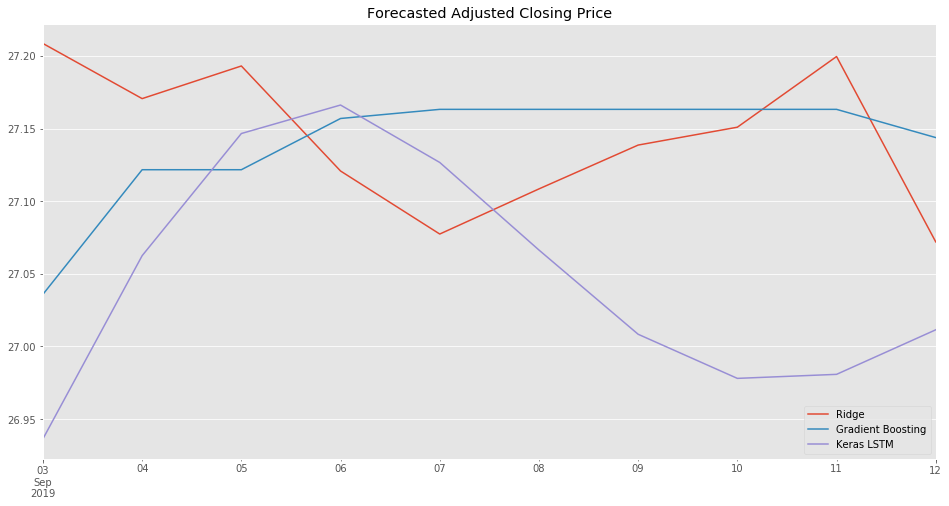

In [112]:
from datetime import timedelta, datetime
last_date = datetime.strptime(df.index[-1], '%Y-%m-%d')
df_forecast = pd.DataFrame()
df_forecast["Ridge"] = values["ridge"]
df_forecast["Gradient Boosting"] = values["gb"]
df_forecast["Keras LSTM"] = values["keras"]
df_forecast.index = pd.date_range(start=last_date, periods=num_days)
df_forecast.plot(label='BAESY', figsize=(16,8), title='Forecasted Adjusted Closing Price', grid=True)